In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import pandas as pd
import numpy as np
from random import randint, uniform
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.metrics.cluster import normalized_mutual_info_score
from datetime import datetime

In [205]:
#load the HTRU_2 dataset and save true class labels as separate array
file_list = drive.ListFile(
    {'q': "'1y2Ypp16D8hE959IrKCADOvpSHz4Tu2Mz' in parents and trashed=false"}).GetList()
downloaded = drive.CreateFile({'id':file_list[0]['id']})   
downloaded.GetContentFile(file_list[0]['originalFilename'])  
data_htru=pd.read_csv(file_list[0]['originalFilename'],header = None)[0:20]
data_htru.insert(0, 'id', data_htru.index)
data_htru.columns=[str(column) for column in data_htru.columns.values]
true_htru=data_htru.iloc[:,-1]
data_htru=data_htru.drop(columns='8')
data_htru.head()

'''data_htru=pd.DataFrame(
    [(1,1,1.5), (2,1,4.5), (3,2,1.5), (4,2,3.5), (5,3,2.5), (6,5,6), (7, 7, 8), (8, 3,7), (9, 4,3)],
     columns=['id','x', 'y']) 
data_htru.head(6)
data_htru.head()
'''

"data_htru=pd.DataFrame(\n    [(1,1,1.5), (2,1,4.5), (3,2,1.5), (4,2,3.5), (5,3,2.5), (6,5,6), (7, 7, 8), (8, 3,7), (9, 4,3)],\n     columns=['id','x', 'y']) \ndata_htru.head(6)\ndata_htru.head()\n"

In [0]:
class Kmeans:
    def __init__(self, k, data):
        self.k=k
        self.original_data = data.copy()
        
        # initialize k centroids with mock values
        self.mock_centroids=pd.DataFrame(
            np.full((self.k,self.original_data.shape[1]),-1.0),
            columns=self.original_data.columns.values)
        self.mock_centroids['id']=np.arange(1,self.k+1)
        
        # assign points to mock clusters
        self.original_data['k']=-1
        self.original_data['distance']=-1
        
        # add suffixes to columns
        self.original_data.columns += '_d'
        self.mock_centroids.columns += '_c'
        
        #create key to allow for join to get cartesian product
        self.original_data['key']=1
        self.mock_centroids['key']=1
        
        # copy dataframes
        self.data=self.original_data.copy()
        self.centroids = self.mock_centroids.copy()

    def assign_centroids(self, dataframe, centroids, i):
        # compute euclidan distance for all combinations       
        df = dataframe.merge(centroids, how='outer')

        df['distance_d'] = np.linalg.norm(
            df[self.data.columns.values.tolist()[1:-3]].values
            -df[self.centroids.columns.values.tolist()[1:-1]].values, axis=1)
        
        # assign centroid that is closest to the record
        df=df.sort_values(['id_d','distance_d']).drop_duplicates(['id_d'],keep='first')
        df.reset_index(inplace=True)
        df['k_d']=df['id_c']
        df=df[self.data.columns.values.tolist()].copy()
        return df
    
    
    def calculate_centroids(self):
        # calculate position of centroids
        cols=self.centroids.columns
        self.centroids=self.data.drop(['id_d','distance_d'], axis=1).groupby(['k_d']).agg(['mean'])
        self.centroids.reset_index(inplace=True) 
        self.centroids.columns=cols
    
    
    def initialize_clusters(self, method='forgy'):
        '''
        Names of methods taken from article:
        A comparative study of efficient initialization methods for the k-means
        clustering algorithm
        
        METHODS:
        
        macqueen - randomly selected points. k distinct cases of the data are 
        randomly selected to be the initial centres. The second method chooses 
        the centers randomly from the data points. The rationale behind this 
        method is that random selection is likely to pick points from dense 
        regions,i.e. points that are good candidates to be centers. 
        
        forgy- assigns each point to one of theKclusters uniformly at random. 
        The centers are then given by the centroids of these initial clusters.
        
        kmpp - random farthest points, or k-means++. 
        The first centre is selected as a random case from the dataset. 
        The 2nd centre is selected also randomly, but the probability of 
        selection of a case is proportional to the distance (square euclidean) 
        of it to that (1st) centre. The 3rd centre is selected also randomly 
        with the probability of selection proportional to the distance of a case
        to the nearest of those two centres, - and so on. 
        (Source: Arthur, D., Vassilvitskii, S.. K-means++: the advantages of 
        careful seeding. //Proceedings of the 18th annual ACM-SIAM symposium on 
        Discrete algorithms. 2007., 1027–1035.)
        
        robin - The ROBIN approach to seed selection is essentially tied to the 
        concept of avoiding outliers as seeds. For this ROBIN first computes 
        the degree to which a point is an outlier, which in turn must consider 
        the local density of the neighboring points. Outliers are those points 
        whose density is very different compared to neighbor densities. 
        In essence the local outlier measure automatically takes into account 
        variable density regions and variable size clusters. The key aim here 
        is to avoid the computation of outlier measure for each point in 
        the dataset, which would yield a worst case method, but rather the 
        challenge is in keeping the complexity very close to linear in n.
        (Source: Robust partitional clustering by outlier and density 
        insensitive seeding)
        '''
        #reset data and centroids
        self.data=self.original_data.copy()
        self.centroids=self.mock_centroids.copy()
        
        if method=='macqueen':
            
            # centroids as random data points
            print(self.data.sample(n=self.k))
            #samples=self.data.sample(n=self.k)
            samples=self.data[0:self.k+1].copy()
            samples.reset_index(inplace=True)
            for i in range(0, self.k):
              for col in self.centroids.columns.values.tolist()[1:-1]:
                  self.centroids.at[i, col]=samples.at[i, col[:-1]+'d']
                
        
        if method == 'forgy':
            # assign points to random clusters (no cluster can be empty)
            while any(init_k not in self.data['k_d'].values 
                      for init_k in range(1,self.k+1)): 
                self.data['k_d']=self.data['k_d'].apply(
                    lambda x: randint(1,self.k))
                
            #calculate initial centroids       
            self.calculate_centroids()
                
        if method == "kmpp":
            df = self.data.copy()
            for i in range(0,self.k):
                if i == 0:
                    # Take one center c1, chosen uniformly at random from X .
                    initial=randint(0,self.k)
                    for col in self.centroids.columns.values.tolist()[1:-1]:
                        self.centroids.at[i,col] = df.at[initial,col[:-1]+'d']      
                            
                else:
                    # Take a new center ci choosing x ∈ X with probability 
                    # D(x) / sum x∈X D(x)
                    df=self.assign_centroids(df, self.centroids.iloc[:i+1,:], i)
                    
                    # calculate square distance
                    df['distance_d']=df['distance_d']**2
                    sum_of_distance=df['distance_d'].sum()
                    df['probability']=df['distance_d']/sum_of_distance
                    
                    # choose  new centroid with probability 
                    # D^2(x) / sum  x∈X D^2(x)
                    select_random=uniform(0,1)
                    cumulant=0
                    for j in range(df.shape[0]):
                        cumulant = cumulant + df.at[j, 'probability']
                        if select_random <= cumulant:
                            for col in self.centroids.columns.values.tolist()[1:-1]:
                                self.centroids.at[i, col] = df.at[j,col[:-1]+'d']
                            break

            
        if method=='robin':
            df=self.data.copy()
            clf = LocalOutlierFactor(n_neighbors=3, novelty=True)
            
            for i in range(0,self.k):
                if i==0:
                    r=self.data.sample(n=1)
                    df['robin_dist']= np.linalg.norm(
                        df[self.data.columns.values.tolist()[1:-3]].values
                        -r[self.data.columns.values.tolist()[1:-3]].values,axis=1)
                    df_sorted=df.sort_values('robin_dist', ascending=False)
                    df_sorted.drop(columns=['k_d','distance_d','key','robin_dist'], inplace=True)
                    df_sorted.reset_index(drop=True,inplace=True) 
                else:
                    df=self.assign_centroids(df, self.centroids.iloc[:i+1,:], i)
                    df_sorted=df.sort_values('distance_d', ascending=False)
                    df_sorted.drop(columns=['k_d','distance_d','key'], inplace=True)
                    df_sorted.reset_index(drop=True,inplace=True)
                      
                for index, row in df_sorted.iloc[:,1:].iterrows():
                    row=pd.DataFrame(row).T.values
                    clf.fit(df_sorted.iloc[:,1:].drop(index=index))
                    LOF=clf.predict(row)
                    if LOF[0]==1:
                        for col in self.centroids.columns.values.tolist()[1:-1]:
                            self.centroids.at[i,col] = df_sorted.at[index,col[:-1]+'d']
                        break

                               
    def plot_clusters(self, dataframe, centroids, i):

        #select subset of dataframe with features
        X = dataframe.copy().drop(columns=['id_d','k_d','distance_d','key'])
        y = dataframe['k_d'].copy().values
        
        X_c = centroids.copy().drop(columns=['id_c']).values
        y_c = centroids['id_c'].copy().values
        
        if X.shape[1] == 2:
            method = 'Plot'
            X_reduced_pca = X.values
        else:
            method = 'PCA'
            # calculate PCA Implementation of dim reducition
            X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)

        #plotting
        f, (ax1) = plt.subplots(1, 1, figsize=(6,6))
        f.suptitle('Iteration ' + str(i), fontsize=14)

        # scatter plot
        ax1.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], 
                    c=y, cmap='rainbow', linewidths=4)
        ax1.scatter(X_c[:,0], X_c[:,1], c=y_c, marker='x', 
                    s=150, cmap='rainbow', linewidths=10)
        ax1.set_title(method, fontsize=14)
        ax1.grid(True)

        plt.show()
        
    
    def Lloyd2(self, make_plots = False):


        i=0
        while True:
            mx_d=self.data.copy().as_matrix()
            mx_c=self.centroids.copy().as_matrix()
            print('ITERATION', i, datetime.now())
            if make_plots:
                self.plot_clusters(self.data, self.centroids, i)
            
            clusters_before = self.data['k_d'].copy().values

            i+=1            
            
            j=0
            for row_d in mx_d:
              min=99999
              for row_c in mx_c:
                  dist = np.linalg.norm(row_d[1:-3] - row_c[1:-1])
                  if dist < min:
                     min = dist
                     k = row_c[0]
              self.data.at[j,'k_d'] = k
              j=j+1
            
            clusters_after = self.data['k_d'].copy().values

            #checking if a cluster disapeared in the process (erronous behaviour)
            # TODO: add exception
            if len(self.data.k_d.unique()) != self.k:
                print('Cluster disapeared, break. Temporary solution.')
                raise Exception

            #check if algorithm converged
            if all(c_before == c_after for c_before, c_after 
                   in zip(clusters_before,clusters_after)):
                break
            
            # update centroids
            self.calculate_centroids()

    def Lloyd(self, make_plots = False):
        converged=False
        i=0
        while not converged:
            if make_plots:
              self.plot_clusters(self.data, self.centroids, i)
            print(i)
            
            i+=1
            clusters_before = self.data['k_d'].values
            self.data=self.assign_centroids(self.data, self.centroids, i)
            clusters_after = self.data['k_d'].values
            
            #check if algorithm converged
            if all(c_before == c_after for c_before, c_after 
                   in zip(clusters_before,clusters_after)):
                converged = True
            
            # update centroids
            self.calculate_centroids()
            
            #checking if a cluster disapeared in the process (erronous behaviour)
            # TODO: add exception
            if len(self.data.k_d.unique()) != self.k:
                print('Cluster disapeared, break. Temporary solution.')
                raise Exception
            

    
    def MacQueen(self, make_plots = False):
        converged=False
        i=0

        while True:
            print('ITERATION', i, datetime.now())

            mx_d=self.data.as_matrix()
            mx_c=self.centroids.as_matrix()
            if make_plots:
                self.plot_clusters(self.data, self.centroids, i)
            
            i+=1            
            clusters_before = self.data['k_d'].copy().values
            
            j=0
            for row_d in mx_d:
              min=99999
              for row_c in mx_c:
                  dist = np.linalg.norm(row_d[1:-3] - row_c[1:-1])
                  if dist < min:
                     min = dist
                     k = row_c[0]
              self.data.at[j,'k_d'] = k

              
              self.calculate_centroids()
              j=j+1
            
            print('iterrows end', datetime.now())

            """
            ['id_d', '0_d', '1_d', '2_d', '3_d', '4_d', '5_d', '6_d', '7_d', 'k_d',
            'distance_d', 'key', 'id_c', '0_c', '1_c', '2_c', '3_c', '4_c', '5_c',
            '6_c', '7_c'],
            -
            'id_d', '0_d', '1_d', '2_d', '3_d', '4_d', '5_d', '6_d', '7_d', 'k_d',
            'distance_d', 'key'],
            -
            'id_c', '0_c', '1_c', '2_c', '3_c', '4_c', '5_c', '6_c', '7_c', 'key']
            """
            #checking if a cluster disapeared in the process (erronous behaviour)
            # TODO: add exception
            if len(self.data.k_d.unique()) != self.k:
                print('Cluster disapeared, break. This is a temporary solution.', self.data.k_d.unique(), self.k)
                raise Exception

            clusters_after = self.data['k_d'].copy().values
            
            #check if algorithm converged
            if all(c_before == c_after for c_before, c_after in zip(clusters_before,clusters_after)):
                break
                

    

In [0]:
ex4 = Kmeans(3,data_htru)
ex4.initialize_clusters(method='macqueen')
ex4.Lloyd(make_plots=True)

In [0]:
ex4 = Kmeans(3,data_htru)
ex4.initialize_clusters(method='macqueen')
ex4.Lloyd2(make_plots=True)


    id_d         0_d        1_d       2_d  ...         7_d  k_d  distance_d  key
19    19   99.367188  41.572202  1.547197  ...    3.662680   -1          -1    1
9      9  107.257812  39.496488  0.465882  ...   57.784738   -1          -1    1
6      6  119.484375  48.765059  0.031460  ...  479.756567   -1          -1    1

[3 rows x 12 columns]
ITERATION 0 2020-03-19 21:46:55.071298


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:289: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:290: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


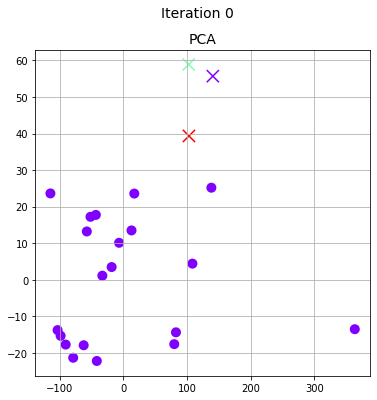

iterrows end 2020-03-19 21:46:55.797582
ITERATION 1 2020-03-19 21:46:55.798330


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:289: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:290: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


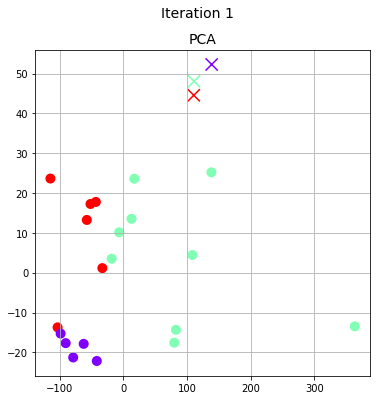

iterrows end 2020-03-19 21:46:56.379407
ITERATION 2 2020-03-19 21:46:56.380149


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:289: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:290: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


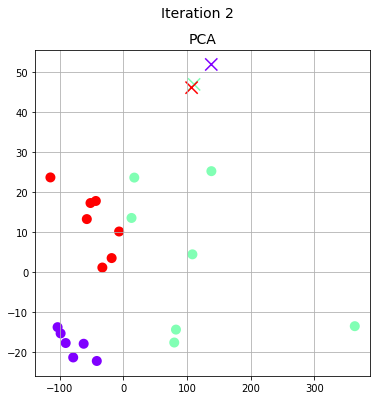

iterrows end 2020-03-19 21:46:56.961633
ITERATION 3 2020-03-19 21:46:56.962321


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:289: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:290: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


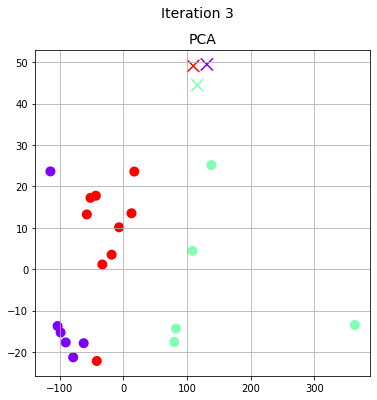

iterrows end 2020-03-19 21:46:57.540001


In [214]:
ex4 = Kmeans(3,data_htru)
ex4.initialize_clusters(method='macqueen')
ex4.MacQueen(make_plots=True)
